<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 6

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

### Скачаем датасет и посмотрим на данные.

In [1]:
!wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY' -O twitter_sentiment.zip

--2022-09-01 09:28:14--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY
Resolving drive.google.com (drive.google.com)... 142.250.4.113, 142.250.4.101, 142.250.4.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hhc1i55jkcbc9oso9vi2rj566gvse8ln/1662024450000/06840004559052771215/*/1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY?e=download&uuid=c6882ee3-071f-4b15-a4d1-abbd18933463 [following]
--2022-09-01 09:28:16--  https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hhc1i55jkcbc9oso9vi2rj566gvse8ln/1662024450000/06840004559052771215/*/1sVla-Yr8ysd2W8m3xNUCMDb2MCDcn0VY?e=download&uuid=c6882ee3-071f-4b15-a4d1-abbd18933463
Resolving doc-00-18-docs.googleusercontent.com (doc-00-18-docs.googleusercontent.com)... 142.

In [2]:
!unzip twitter_sentiment.zip

Archive:  twitter_sentiment.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### Проверим датасет на пропуски и типы данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


### А так же на наличие дубликатов

In [7]:
df.duplicated().sum()

0

### Посмотрим на количество и соотношение меток целевого класса

In [8]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

### В датасете собраны твиты двух тональностей. Значит необходимо произвести классификацию на два класса.

1 - negative<br>
0 - positive

### Посмотрим на тестовый датасет

In [9]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


### Датасет содержит только id и tweet-текст.



### Так как в размеченном датасете наблюдается сильный дисбаланс классов, то для корректной работы сети применим стратифицированное разделение на тренировочный и валидационный датасет. 

In [11]:
fractions = np.array([0.7, 0.3])
# shuffle your input
df = df.sample(frac=1) 
# split into 2 parts
df_train, df_val = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [12]:
df_train.head()

,id,label,tweet
29918,29919,0,i'm not entirely sure if i'm or sad or both ...
31094,31095,0,â #nist plans cybersecurity framework upda...
17183,17184,0,thinking out loud!!! #lowkey #realhappy #j...
4998,4999,0,"@user #bestsellers #top10 #sales ""never go ..."
28642,28643,0,counting down the days until i can come home a...


In [13]:
df_train['label'].value_counts()

0    20833
1     1540
Name: label, dtype: int64

In [14]:
df_val['label'].value_counts()

0    8887
1     702
Name: label, dtype: int64

### Проведем предварительную обработку датасета

In [15]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

### Так как твиты на английском языке - загрузим английскую версию stop_words

In [17]:
sw = set(get_stop_words('en'))
# sw

In [18]:
puncts = set(punctuation)
# puncts

In [19]:
morpher = MorphAnalyzer()
# morpher.parse('extracted')[0].normal_form

In [20]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    # txt = re.sub("не\s", "не", txt)
    txt = re.sub('@user', '', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

### Проверим как работает функция очистки текста

In [21]:
df_train['tweet'].iloc[:1].values

array(["i'm not entirely sure if i'm   or sad or both or neither or #hungry or tired or bored. i just don't even know.. "],
      dtype=object)

In [22]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['im entirely sure im sad neither hungry tired bored just dont even know'],
      dtype=object)

In [23]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:02<00:00, 4618.06it/s]


In [24]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [25]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['im', 'entirely', 'sure', 'im', 'sad']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [26]:
tokens_filtered = [word for word in tokens if word.isalnum()]

### Зададим необходимые параметры:

In [27]:
max_words = 4000
max_len = 20
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [28]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

3999

In [29]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'im', 'u', 'life']

In [45]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [31]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [32]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 3.61 s, sys: 17.5 ms, total: 3.63 s
Wall time: 3.66 s


In [33]:
x_train.shape

(22373, 20)

In [34]:
df_train['tweet'].iloc[0]

'im entirely sure im sad neither hungry tired bored just dont even know'

In [35]:
x_train[0]

array([   8,  479,    8,   62, 3923,  956,  399, 1178,    6,   25,   83,
         56,    0,    0,    0,    0,    0,    0,    0,    0])

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [37]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [38]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [39]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [40]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(4000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 602497


In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [43]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/5]. Step [44/44]. Loss: 0.230. Acc: 0.911. Test loss: 0.621. Test acc: 0.927
Epoch [2/5]. Step [44/44]. Loss: 0.194. Acc: 0.931. Test loss: 0.504. Test acc: 0.927
Epoch [3/5]. Step [44/44]. Loss: 0.219. Acc: 0.931. Test loss: 0.116. Test acc: 0.927
Epoch [4/5]. Step [44/44]. Loss: 0.180. Acc: 0.931. Test loss: 0.228. Test acc: 0.927
Epoch [5/5]. Step [44/44]. Loss: 0.104. Acc: 0.949. Test loss: 0.049. Test acc: 0.941
Training is finished!


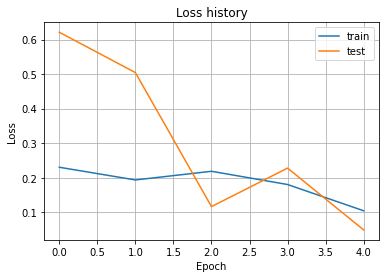

In [44]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

### В процессе экспериментов приемлемый результат от сети удалось получить применив стратифицированное разделение данных, изменив параметр max_words = 4000 и уменьшив скорость обучения до 0.001.

### Предсказание на тестовом датасете не выполнял, поскольку нет возможности проверить его точность.